# Perform online segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../dev/
from dataset_creation_aprovis3d import aprovis3dDataset

/home/antoine/homhots/aprovhots/dev


In [3]:
import tonic, torch, os, pickle, copy, sys, glob
from tqdm import tqdm
from hots.network import network
from hots.layer import mlrlayer
from hots.timesurface import timesurface
from hots.utils import apply_jitter, get_loader, get_dataset_info, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import imageio.v3 as iio
from IPython.display import Image
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

data_path = '../../Data/RGB_frames2events/'
# gives the data type - here we use experimental data, stored as npy

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [4]:
data_type = 'synthetic'
# gives a patch_size to divide spatially the event streams
patch_size = (672, 376)
# gives a max duration for the samples of the dataset to divide temporally the event streams
max_duration = 1e3 # (in ms)
# labels given to the different classes of the dataset
labelz = ['sea','gro']
# original sensor_size of the DVS (width,height,polarity)
sensor_size = [672, 376, 2]
# discard samples with less than min_num_events events
min_num_events = 1000
# split the recordings into train and test sets with train_test_ratio ratio
train_test_ratio = .75
# gives the indexing of the event stream
ordering = 'xytp'

trainset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
testset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=False, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
trainloader = get_loader(trainset)
testloader = get_loader(testset)

num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(trainset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 69
number of samples in the testing set: 24


## Run the core HOTS network

In [5]:
name = 'homeohots'
homeo = True
timestr = '2023-01-03'
dataset_name = 'aprovis_UCA_no_patch'
ts_batch_size = int(2e4)

tau_0 = 6e3
tau_0 = 2e4

Rz = [4, 8]
N_neuronz = [64, 16]
tauz = [tau_0*2, tau_0*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
    os.mkdir(record_path+'output/')
    os.mkdir(record_path+'output/train/')
    os.mkdir(record_path+'output/test/')
    os.mkdir(record_path+'LR_results/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(trainloader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size)

In [6]:
hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=True, ts_batch_size = ts_batch_size, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=False, ts_batch_size = ts_batch_size, verbose=False)

In [7]:
jitter = (None, None)
type_transform = tonic.transforms.NumpyAsType(int)
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/test/{hots.name}_{num_sample_test}_{jitter}/'
#trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
#testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)

## Divide the event streams into 16x16 patches

In [8]:
patch_size = (64, 64)
max_duration = None
min_num_events = 10
kfold = None

#weird way of splitting dataset between trainsets and testsets but works -> to improve
trainset_output = aprovis3dDataset(save_to=train_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
testset_output = aprovis3dDataset(save_to=test_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
trainloader_output = get_loader(trainset_output, kfold = kfold)
testloader_output = get_loader(testset_output)
print(f'number of samples in the training set: {len(trainloader_output)}')
print(f'number of samples in the testing set: {len(testloader_output)}')

number of samples in the training set: 3218
number of samples in the testing set: 1172


## Example with only one layer of Multinomial Logistic Regression (MLR)

In [9]:
ts_batch_size = int(1e3) 
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
betas = (0.9, 0.999)
num_epochs = 2 ** 5 + 1
N_polarities = N_neuronz[-1]
ts_size = (trainset_output.sensor_size[0],trainset_output.sensor_size[1],N_polarities)
tau_cla = 6e4*32
mlr_layer_name = f'{timestr}_LR_patches_{tau_cla}_{ts_size}_{learning_rate}_{betas}_{num_epochs}_{kfold}_{jitter}.pkl'

model_path = record_path+'networks/' + mlr_layer_name
results_path = record_path+'LR_results/' + mlr_layer_name
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/train/{hots.name}_{num_sample_test}_{jitter}/'

classif_layer, losses = fit_mlr(trainloader_output, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size,)

Number of chance decisions: 0
90th quantile for number of events: 11507.200000000008
Mean accuracy: 68.10000000000001%
Last accuracy: 61.3%
Highest probability accuracy: 56.10000000000001%


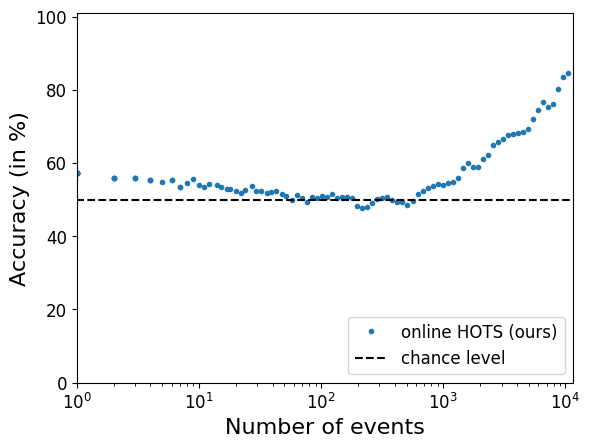

In [10]:
mlr_threshold = None

onlinac = online_accuracy(classif_layer, tau_cla, testloader_output, results_path, ts_size, trainset.ordering, len(labelz), mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, original_accuracy = None, original_accuracy_nohomeo = None, online_plot=True)

In [11]:
data_type = 'synthetic'
# gives a patch_size to divide spatially the event streams
patch_size = (672, 376)
# gives a max duration for the samples of the dataset to divide temporally the event streams
max_duration = None # (in ms)
# labels given to the different classes of the dataset
labelz = ['sea', 'gro', 'mix']
# original sensor_size of the DVS (width,height,polarity)
sensor_size = [672, 376, 2]
# discard samples with less than min_num_events events
min_num_events = 1000
# split the recordings into train and test sets with train_test_ratio ratio
train_test_ratio = 1
# gives the indexing of the event stream
ordering = 'xytp'

mixedset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=False, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, mixed=True)
mixedloader = get_loader(mixedset)

num_sample_mixed = len(mixedloader)
print(f'number of samples in the training set: {len(mixedloader)}')

number of samples in the training set: 2


In [12]:
hots.name = initial_name + '_mixed'
hots.coding(mixedloader, ordering, labelz, filtering_threshold=None, training=False, ts_batch_size=int(1e4), verbose=False)
mixed_path = record_path+f'output/test/{hots.name}_{num_sample_mixed}_{jitter}/'

In [13]:
list_files_mixed = glob.glob(glob.escape(mixed_path)+'mix/*.npy')

In [14]:
patch_size = (64, 64)
max_duration = None
min_num_events = 10
kfold = None

In [43]:
def predict_and_divide(events, 
                mlrlayer,
                tau_cla,
                results_path,
                timesurface_size,
                sensor_size,
                ordering,
                save = True,
                device = 'cuda',
                ts_batch_size = None,
        ):
    if os.path.isfile(results_path+'.npy'):
        events_outputs = np.load(results_path+'.npy')
    else:    
        N = timesurface_size[0]*timesurface_size[1]*timesurface_size[2]
        t_index = ordering.index('t')
        x_index = ordering.index('x')
        y_index = ordering.index('y')
        p_index = ordering.index('p')
        #initial_memory = copy.copy(torch.cuda.memory_allocated())
        classif_layer = mlrlayer.to(device)
        
        width, height = sensor_size[0], sensor_size[1]
        patch_width, patch_height = timesurface_size[0], timesurface_size[1]
        assert width>patch_width
        assert height>patch_height
        
        with torch.no_grad():
            # needed for previous versions, now it should be ok to remove it
            classif_layer.linear = classif_layer.linear.double()
            likelihood, true_target, timestamps = [], [], []

            events = torch.Tensor(events)
            
            events_outputs = torch.Tensor([]).to(device)
            
            num_patches = width//patch_width * height//patch_height
            pbar = tqdm(total=num_patches)
            
            for x in range(width//patch_width):
                for y in range(height//patch_height):
                    events_patch = events[
                                   (events[:,x_index]>=x*patch_width)&(events[:,x_index]<(x+1)*patch_width)&
                                   (events[:,y_index]>=y*patch_height)&(events[:,y_index]<(y+1)*patch_height)]
                    
                    if events_patch.shape[0]==0:
                        pbar.update(1)
                        break
                    else:
                        events_patch[:,x_index] -= x*patch_width
                        events_patch[:,y_index] -= y*patch_height

                        timestamps.append(events_patch[:,t_index])

                        outputs = torch.Tensor([]).to(device)
                        ind_outputs = torch.Tensor([]).to(device)

                        if events_patch.shape[1]>0:
                            if ts_batch_size and len(events_patch)>ts_batch_size:
                                nb_batch = len(events_patch)//ts_batch_size+1
                                previous_timestamp = []
                                for load_nb in range(nb_batch):
                                    X, ind_filtered, previous_timestamp = timesurface(events_patch, (timesurface_size[0], timesurface_size[1], timesurface_size[2]), ordering, tau = tau_cla, ts_batch_size = ts_batch_size, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                    n_events = X.shape[0]
                                    X = X.reshape(n_events, N)
                                    outputs_splitted = classif_layer(X.double())
                                    outputs = torch.vstack([outputs,outputs_splitted]) if outputs.shape[0]>0 else outputs_splitted
                                    ind_outputs = torch.hstack([ind_outputs,ind_filtered+load_nb*ts_batch_size]) if ind_outputs.shape[0]>0 else ind_filtered
                                    del X, outputs_splitted
                                    torch.cuda.empty_cache()
                            else:
                                X, ind_filtered = timesurface(events_patch, (timesurface_size[0], timesurface_size[1], timesurface_size[2]), ordering, tau = tau_cla, device=device)
                                ind_outputs = ind_filtered
                                n_events = X.shape[0]
                                X = X.reshape(n_events, N)
                                outputs = classif_layer(X.double())
                                del X
                            events_patch = events_patch[ind_outputs,:]
                            events_patch[:,p_index] = outputs.argmax(1).cpu()
                            events_patch[:,x_index] += x*patch_width
                            events_patch[:,y_index] += y*patch_height

                            events_outputs = torch.vstack([events_outputs,events_patch]) if events_outputs.shape[0]>0 else events_patch

                            del outputs
                            torch.cuda.empty_cache()
                            pbar.update(1)

            events_outputs = events_outputs[events_outputs[:,ordering.index('t')].argsort()]
            np.save(results_path, events_outputs)

    return events_outputs

In [44]:
indice = 0
events = np.load(list_files_mixed[indice])
events_outputs = predict_and_divide(events, classif_layer, tau_cla, results_path[:-4]+f'_mixed_{indice}',ts_size,sensor_size,ordering,ts_batch_size = 1000)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 50/58 [19:21<03:05, 23.24s/it]


In [45]:
print(events.shape, events_outputs.shape)

(5774283, 4) torch.Size([5000058, 4])


In [46]:
time_duration = events[-1,trainset.ordering.index('t')] - events[0,trainset.ordering.index('t')]
print(f'Time duration of the recording: {np.round(time_duration/1e6,2)} seconds')

Time duration of the recording: 20.74 seconds


In [ ]:
from hots.utils import make_and_display_ts

file_name = f'mixed_ts_{indice}_reduced'#results_path[:-4]+f'_mixed_{indice}_ts'
make_and_display_ts(torch.Tensor(events_outputs), file_name, mixedset, tau_cla, polarity= 'off', nb_frames = 50, ts_batch_size = int(1e3))

Building .gif ...



 15%|███████████████████████████████████                                                                                                                                                                                                 | 769/5001 [11:03<1:00:50,  1.16it/s]

In [ ]:
make_and_display_ts(torch.Tensor(events_outputs), file_name, mixedset, tau_cla, polarity = 'on', nb_frames = 50, ts_batch_size = int(1e3))

In [25]:
np.unique(events_outputs[:,1])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15